In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from utils.helper import load_and_summarize

In [2]:
df_liver_raw = load_and_summarize('CSV Files/liver_patient.csv')

--- Loading liver_patient.csv ---
First 5 rows:
   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62    Male              7.3               4.1                   490   
3   58    Male              1.0               0.4                   182   
4   72    Male              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Dataset  


In [3]:
# Preprocessing
df_liver = df_liver_raw.drop('Gender', axis=1)
df_liver.dropna(inplace=True)
df_liver['Dataset'] = df_liver['Dataset'].replace(2, 0) 

# Separate features (X) and target (y)
X = df_liver.drop('Dataset', axis=1)
y = df_liver['Dataset']

print("\nData loaded and cleaned successfully.")


Data loaded and cleaned successfully.


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features have been standardized.")

Features have been standardized.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (463, 9)
Testing set shape: (116, 9)


In [6]:
# -Apply PCA ---
# We will reduce the features from 9 down to 2 principal components for visualization.
pca = PCA(n_components=2)

# Fit PCA on the training data ONLY to learn the principal components.
pca.fit(X_train)

PCA(n_components=2)

In [7]:
# Transform both the training and testing data using the learned components.
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_train_pca.shape[1]}")
print(f"\nExplained variance by Component 1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Explained variance by Component 2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained by 2 components: {np.sum(pca.explained_variance_ratio_):.2%}")

Original number of features: 9
Reduced number of features: 2

Explained variance by Component 1: 30.19%
Explained variance by Component 2: 22.09%
Total variance explained by 2 components: 52.28%


In [8]:
# --- 6.1: Train SVM on PCA-Transformed Data ---
svm_pca = SVC(random_state=42)
svm_pca.fit(X_train_pca, y_train)

# --- 6.2: Evaluate the Model ---
y_pred_pca = svm_pca.predict(X_test_pca)
pca_accuracy = accuracy_score(y_test, y_pred_pca)

print(f"Accuracy of SVM on PCA-reduced data: {pca_accuracy:.4f}")

Accuracy of SVM on PCA-reduced data: 0.6293


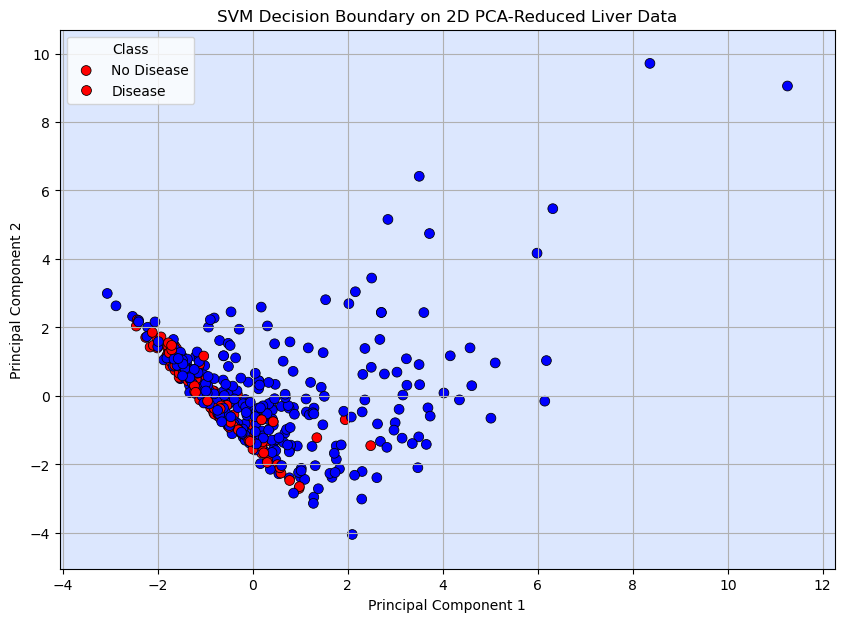

In [9]:
# Plot the PCA-transformed data and the SVM decision boundary 
def plot_pca_decision_boundary(model, X, y, title):
    plt.figure(figsize=(10, 7))
    
    # Create a meshgrid for the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    # Predict on the meshgrid to get the decision boundary
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

    sns.scatterplot(
        x=X[:, 0], y=X[:, 1], hue=y,
        palette=['red', 'blue'], marker='o', s=50,
        edgecolor='k'
    )

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Class', labels=['No Disease', 'Disease'])
    plt.grid(True)
    plt.show()

plot_pca_decision_boundary(svm_pca, X_train_pca, y_train, 'SVM Decision Boundary on 2D PCA-Reduced Liver Data')